In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os 
os.chdir('/content/drive/MyDrive/Alzheimer dataset')
print('We are inside the folder', os.getcwd())

We are inside the folder /content/drive/MyDrive/Alzheimer dataset


In [ ]:
data= '/content/drive/MyDrive/Alzheimer dataset/'


In [ ]:
train_path= data + "//train"
os.listdir(train_path)

['NonDemented', 'VeryMildDemented', 'ModerateDemented', 'MildDemented']

In [ ]:
test_path= data + "//test"
os.listdir(test_path)

['ModerateDemented', 'VeryMildDemented', 'NonDemented', 'MildDemented']

In [ ]:
print("No. of images in NonDemented:", len(os.listdir(train_path+ '//NonDemented')))
print("No. of images in MildDemented:", len(os.listdir(train_path+ '//MildDemented')))
print("No. of images in VeryMildDemented:", len(os.listdir(train_path+ '//VeryMildDemented')))
print("No. of images in ModerateDemented:", len(os.listdir(train_path+ '//ModerateDemented')))

No. of images in NonDemented: 2560
No. of images in MildDemented: 717
No. of images in VeryMildDemented: 1792
No. of images in ModerateDemented: 52


In [ ]:
print("No. of images in NonDemented:", len(os.listdir(test_path+ '//NonDemented')))
print("No. of images in MildDemented:", len(os.listdir(test_path+ '//MildDemented')))
print("No. of images in VeryMildDemented:", len(os.listdir(test_path+ '//VeryMildDemented')))
print("No. of images in ModerateDemented:", len(os.listdir(test_path+ '//ModerateDemented')))

No. of images in NonDemented: 640
No. of images in MildDemented: 179
No. of images in VeryMildDemented: 448
No. of images in ModerateDemented: 12


In [ ]:
import os
from distutils.dir_util import copy_tree, remove_tree

In [ ]:
work_dir = data+ "dataset/"

if os.path.exists(work_dir):
  remove_tree(work_dir)


os.mkdir(work_dir)
copy_tree(train_path, work_dir)
copy_tree(test_path, work_dir)
print("Working directories: ", os.listdir(work_dir))

Working directories:  ['NonDemented', 'VeryMildDemented', 'ModerateDemented', 'MildDemented']


In [ ]:
data_dir= './dataset/'
#os.listdir(data_dir)

classes = ['NonDemented', 'MildDemented', 'VeryMildDemented', 'ModerateDemented']

IMG_SIZE= 176
IMAGE_SIZE= [176, 176]
DIM= (IMG_SIZE, IMG_SIZE)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Performing Image Augmentation

ZOOM= [.99, 1.01]
BRIGHT_RANGE= [0.8, 1.2]
HORZ_FLIP= True
FILL_MODE= 'constant'
DATA_FORMAT= 'channels_last'

work_dr= ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, 
                            zoom_range=ZOOM, data_format=DATA_FORMAT, 
                            fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)


train_data_gen = work_dr.flow_from_directory(directory=data_dir, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [ ]:
#Retrieving the data from the ImageDataGenerator iterator

'''
The next function returns a batch from the dataset. 
The return value of next function is in form of (x_train, y_train) where x_train is training features and y_train, its labels
'''

train_data, train_labels = train_data_gen.next()

In [ ]:
#Getting shape of dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced
sm= SMOTE(random_state=42)
train_data, train_labels= sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE* 3), train_labels)

train_data= train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
print("Size of Train data: ", len(train_data))
print("Size of Test data: ", len(test_data))
print("Size of Val data: ", len(val_data), '\n')
print("Size of Train Labels: ", len(train_labels))
print("Size of Test Labels: ", len(test_labels))
print("Size of Val Labels: ", len(val_labels))

Size of Train data:  8192
Size of Test data:  2560
Size of Val data:  2048 

Size of Train Labels:  8192
Size of Test Labels:  2560
Size of Val Labels:  2048


Model Building

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt



from PIL import Image
from random import randint

import tensorflow.keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

Loading Transfer learning Model

In [ ]:
model = InceptionV3(input_shape=(176,176,3), include_top= False, weights="imagenet")


87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
#Turning off the traning layers

for layer in model.layers:
  layer.trainable= False

In [ ]:
custom_model= Sequential([
                          model,
                          Dropout(0.5),
                          GlobalAveragePooling2D(),
                          Flatten(),
                          BatchNormalization(),
                          Dense(512, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(256, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(128, activation='relu'),
                          BatchNormalization(),
                          Dropout(0.5),
                          Dense(64, activation='relu'),
                          Dropout(0.5),
                          BatchNormalization(),
                          Dense(4, activation='softmax')], name= "custom_model")

In [ ]:
custom_model.summary()

Model: "custom_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout_10 (Dropout)        (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_104 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            (None, 512)              

In [ ]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoc, logs={}):
    if logs.get('Accuracy')>0.99:
      print("\n Reached accuracy...Stopped Traning")
      self.model.stop_training= True

my_callback= MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback= ReduceLROnPlateau(moniter= "val_loss", patience=3)




In [ ]:
#pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.1 MB/s 


In [ ]:
import tensorflow_addons as tfa

In [ ]:
METRICS= [tf.keras.metrics.CategoricalAccuracy(name= 'Accuracy'),
          tf.keras.metrics.AUC(name= 'AUC'),
          tfa.metrics.F1Score(num_classes=4)]

CALLBACKS= [my_callback, rop_callback]



In [ ]:
#Compile the model 

custom_model.compile(optimizer= 'adam', loss= tf.losses.CategoricalCrossentropy(), metrics= METRICS)

In [ ]:
#Model Training 
EPOCHS = 50
history= custom_model.fit(train_data,
                          train_labels, 
                          validation_data= (val_data, val_labels), 
                          callbacks= CALLBACKS, 
                          epochs= EPOCHS)

Epoch 1/50
256/256 [==============================] - 20s 56ms/step - loss: 1.4295 - Accuracy: 0.3873 - AUC: 0.6524 - f1_score: 0.3847 - val_loss: 0.8609 - val_Accuracy: 0.6118 - val_AUC: 0.8707 - val_f1_score: 0.5951 - lr: 0.0010
Epoch 2/50
256/256 [==============================] - 13s 49ms/step - loss: 0.9903 - Accuracy: 0.5415 - AUC: 0.8185 - f1_score: 0.5337 - val_loss: 0.7429 - val_Accuracy: 0.6558 - val_AUC: 0.8965 - val_f1_score: 0.6150 - lr: 0.0010
Epoch 3/50
256/256 [==============================] - 13s 49ms/step - loss: 0.8366 - Accuracy: 0.6075 - AUC: 0.8688 - f1_score: 0.5951 - val_loss: 0.6645 - val_Accuracy: 0.6821 - val_AUC: 0.9170 - val_f1_score: 0.6506 - lr: 0.0010
Epoch 4/50
256/256 [==============================] - 13s 49ms/step - loss: 0.7698 - Accuracy: 0.6475 - AUC: 0.8901 - f1_score: 0.6333 - val_loss: 0.6319 - val_Accuracy: 0.7061 - val_AUC: 0.9250 - val_f1_score: 0.6894 - lr: 0.0010
Epoch 5/50
256/256 [==============================] - 13s 49ms/step - loss: 

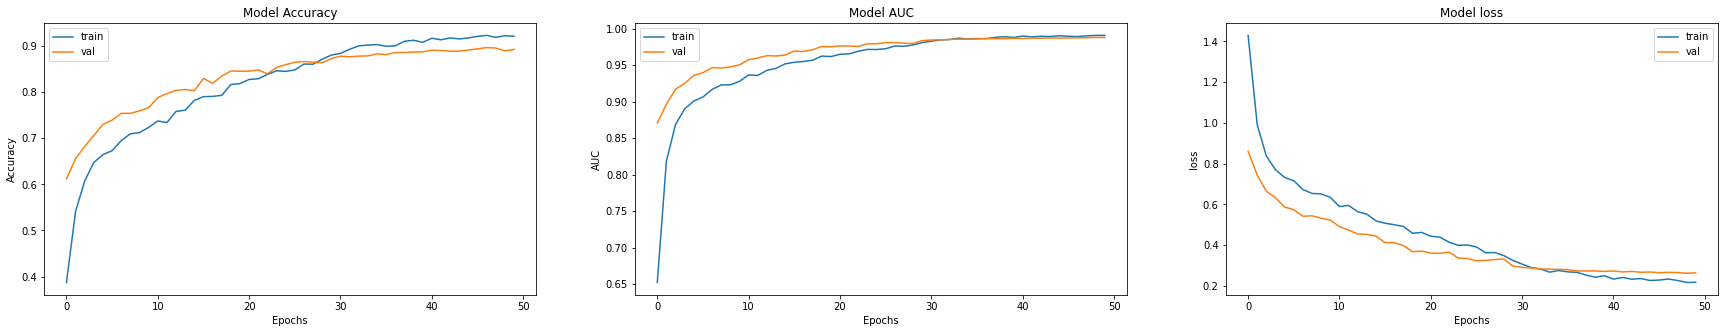

In [ ]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["Accuracy", "AUC", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

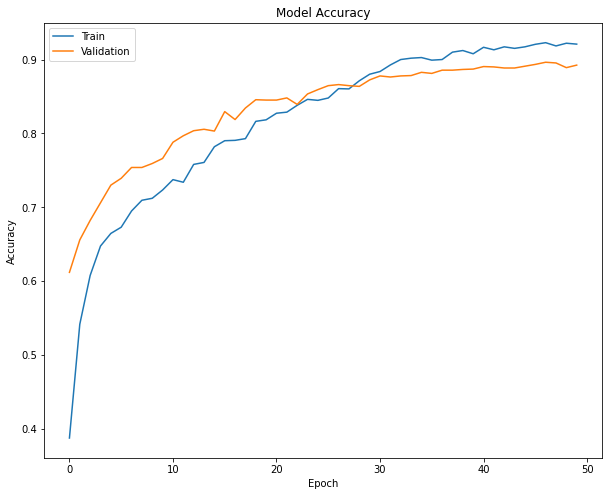

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
#Evaluating the model on the data

test_scores = custom_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 3s 39ms/step - loss: 0.2843 - Accuracy: 0.8902 - AUC: 0.9856 - f1_score: 0.8900
Testing Accuracy: 89.02%


In [ ]:
train_scores = custom_model.evaluate(train_data, train_labels)
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))

256/256 [==============================] - 10s 39ms/step - loss: 0.0446 - Accuracy: 0.9897 - AUC: 0.9998 - f1_score: 0.9897
Training Accuracy: 98.97%


In [ ]:
val_scores = custom_model.evaluate(val_data, val_labels)
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))

64/64 [==============================] - 3s 40ms/step - loss: 0.2639 - Accuracy: 0.8926 - AUC: 0.9878 - f1_score: 0.8915
Validation Accuracy: 89.26%


In [ ]:
#Predicting the test data

pred_labels = custom_model.predict(test_data)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

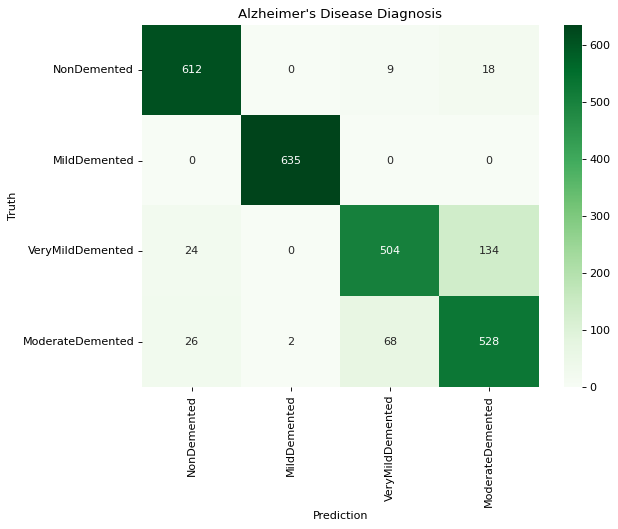

In [ ]:
#Plotting confusion matrix

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_mtx= confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_mtx, cmap='Greens', annot=True, fmt='d', xticklabels= classes,
                yticklabels=classes)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
model.save("Alzmr_inptnV3_model.h5")

In [ ]:
custom_model_dir= data + "Alzmr_inptnV3_model"
custom_model.save(custom_model_dir, save_format='h5')


['NonDemented',
 'VeryMildDemented',
 'ModerateDemented',
 'MildDemented',
 '.ipynb_checkpoints']

In [ ]:
os.listdir(data)

['train', 'test', 'dataset', '.ipynb_checkpoints', 'Alzmr_inptnV3_model']

In [ ]:
# Load the  model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Alzheimer dataset/Alzmr_inptnV3_model')

In [ ]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100), '\n')

train_scores = model.evaluate(train_data, train_labels)
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100), '\n')

val_scores = model.evaluate(val_data, val_labels)
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100),'\n')

80/80 [==============================] - 3s 40ms/step - loss: 0.2843 - Accuracy: 0.8902 - AUC: 0.9856 - f1_score: 0.8900
Testing Accuracy: 89.02% 

256/256 [==============================] - 10s 40ms/step - loss: 0.0446 - Accuracy: 0.9897 - AUC: 0.9998 - f1_score: 0.9897
Training Accuracy: 98.97% 

64/64 [==============================] - 3s 39ms/step - loss: 0.2639 - Accuracy: 0.8926 - AUC: 0.9878 - f1_score: 0.8915
Validation Accuracy: 89.26% 



Model Testing

In [ ]:
import os 
os.chdir('/content/drive/MyDrive/Alzheimer dataset')
print('We are inside the folder', os.getcwd())

We are inside the folder /content/drive/MyDrive/Alzheimer dataset


In [ ]:
data= '/content/drive/MyDrive/Alzheimer dataset/'

In [ ]:
import keras
import cv2
from keras.models import load_model, Model
import numpy as np
from keras.preprocessing import image

In [ ]:
#https://programmerah.com/keras-import-a-custom-metric-model-error-unknown-metric-function-please-ensure-this-object-is-passed-tocustom_object-29884/

# Load the  model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Alzheimer dataset/Alzmr_inptnV3_model', compile = False)
print('.............Model Loaded..........')

.............Model Loeaded..........


In [ ]:
file_path= '/content/drive/MyDrive/Alzheimer dataset/test/MildDemented/26 (19).jpg' #class:0
#file_path= '/content/drive/MyDrive/Alzheimer dataset/test/ModerateDemented/27 (2).jpg' #class:1
#file_path= '/content/drive/MyDrive/Alzheimer dataset/test/NonDemented/26 (100).jpg' #class:2
#file_path= '/content/drive/MyDrive/Alzheimer dataset/test/VeryMildDemented/26 (44).jpg' #class:3

In [ ]:
img = cv2.imread(file_path)
imgs = cv2.resize(img, (176,176))
img1=image.img_to_array(imgs)
img1=img1/255
img1=np.expand_dims(img1,axis=0)
#img2= preprocess_input(img1)
print(img1.shape)


(1, 176, 176, 3)


In [ ]:
result = model.predict(img1)
result

array([[9.4689626e-01, 1.5881499e-04, 1.9215878e-02, 3.3729058e-02]],
      dtype=float32)

In [ ]:
classes1= ['0 - MildDemented', '1 - ModerateDemented', '2 - NonDemented', '3 - VeryMildDemented']
num_classes = len(classes1)
print (classes1)

['0 - MildDemented', '1 - ModerateDemented', '2 - NonDemented', '3 - VeryMildDemented']


In [ ]:
predicted_probs= []
predicted_classes=[]

sorted_prob_idxs = (-result).argsort()[0]  #perform an indirect sort along the given axis using the algorithm specified by the kind keyword.
predicted_prob = np.amax(result)           #Return the maximum of an array or maximum along an axis.
predicted_probs.append(predicted_prob)

predicted_class = classes1[sorted_prob_idxs[0]]    #axis=0 raw-wise
predicted_classes.append(predicted_class)
print (result, '\n')
print("Class Type: ", predicted_class)

[[9.4689626e-01 1.5881499e-04 1.9215878e-02 3.3729058e-02]] 

Class Type:  0 - MildDemented
